In [127]:
#import the necessary librarires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Read the data
df=pd.read_csv("dinos.csv")

In [3]:
#Check for null values
df.isna().sum()

Species         0
Weight          0
Length          0
Age             0
TailLength      0
Height          0
Width           0
Gender          0
Completeness    0
dtype: int64

In [4]:
#A function to split the data into training and testing set
def test_train_split(data):
    train_index={1}
    #This function will get random indexes which will be 70% of the total number of samples
    while(len(train_index)<0.7*len(data)):
        train_index.add(np.random.randint(1,158+1)) #We are using a set so that the duplicate 
                                    #indices are not taken in
            
    train_index=list(train_index)  
    test_index=[x for x in range(1,158+1) if x not in train_index]
    train_data=data.iloc[train_index]
    test_data=data.iloc[test_index]
    test_data=test_data.reset_index().drop("index",axis=1)
    train_data=train_data.reset_index().drop("index",axis=1)
    return train_data,test_data

## Let's do feature engineering before splitting the dataset into training and testing sets

In [7]:
species=df["Species"].unique() 
species##There are only 6 species and obv, specie is an indicator of how much the weight can be, so let's encode them 

array(['Iguanadon', 'Pterodactyl', 'Brachiosaurus', 'Raptor',
       'Vulcanodon', 'Stegosaurus', 'Plateosaurus'], dtype=object)

In [8]:
for i in range(len(species)):
    df["Species"]=df["Species"].replace(species[i],i+1)

In [9]:
df["Gender"]=df["Gender"].replace("M",0)
df["Gender"]=df["Gender"].replace("F",1)

In [10]:
train,test=test_train_split(df)

###  The data has been split, let's try using plain Linear Regression to predict the weights.

In [11]:
X_train=train.drop(["Weight"],axis=1)
Y_train=train["Weight"]

In [12]:
X_train.shape

(112, 8)

In [74]:
def Normalize(data):
    return (data-data.mean())/data.std()

def Linear_Reg(X_train,Y_train,epochs,lr,train=True):
    if("Bias" not in X_train.columns): #Add the Bias Column if not already present
        X_train.insert(0,"Bias",np.ones(len(X_train)))
    cost_history=[]
    num_samples,num_features=X_train.shape
    weights=np.random.randn(num_features)
    #Training part
    for epoch in range(epochs):
        out=np.dot(X_train,weights)
        error=(out-Y_train)

        loss= (error**2)/num_samples
        
        cost_history.append(loss)

        gradient = np.dot(X_train.T,  error) / len(X_train)

        weights-= lr * gradient #Weight Updation
    return weights,cost_history

In [50]:
X_train_norm=Normalize(X_train)
Y_train_norm=Normalize(Y_train)

In [77]:
weights_5,cost_history_5=Linear_Reg(X_train_norm,Y_train_norm,epochs=5000,lr=0.1)
weights_10,cost_history_10=Linear_Reg(X_train_norm,Y_train_norm,10000,0.1)
weights_15,cost_history_15=Linear_Reg(X_train_norm,Y_train_norm,15000,0.1)

In [78]:
#Changing only the learning rate
weights_lr1,cost_history_lr1=Linear_Reg(X_train_norm,Y_train_norm,epochs=10000,lr=0.1)
weights_lr2,cost_history_lr2=Linear_Reg(X_train_norm,Y_train_norm,10000,0.01)
weights_lr3,cost_history_lr3=Linear_Reg(X_train_norm,Y_train_norm,10000,0.001)

In [62]:
def R2_score(y_pred,y_true):
    sum_of_residuals=((y_true-y_pred)**2).mean()
    sum_of_squares=((y_true-y_true.mean())**2).mean()
    return 1-((sum_of_residuals)/sum_of_squares)

In [129]:
R2_scores_weights=list(map(lambda w : R2_score(X_train_norm@w,Y_train_norm), [weights_5,weights_10,weights_15]))
R2_scores_lr=list(map(lambda w : R2_score(X_train_norm@w,Y_train_norm), [weights_lr1,weights_lr2,weights_lr3]))

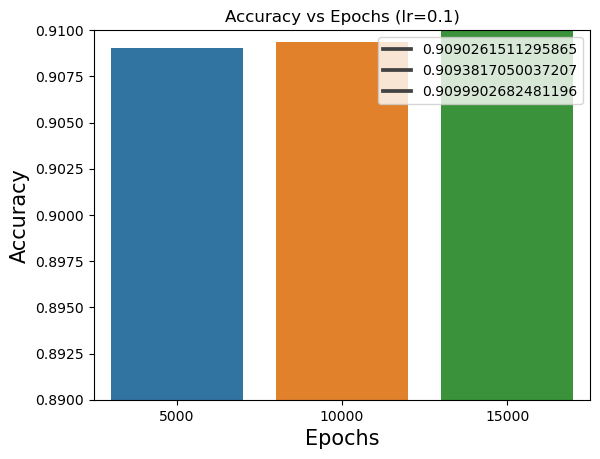

In [142]:
ax=sns.barplot(x=Epochs,y=R2_scores_weights)
legend=ax.legend(R2_scores_weights)
title=ax.set_title("Accuracy vs Epochs (lr=0.1)")
ax.set_xlabel("Epochs",size=15)
ax.set_ylim([0.890,0.910])
ylabel=ax.set_ylabel("Accuracy",size=15)

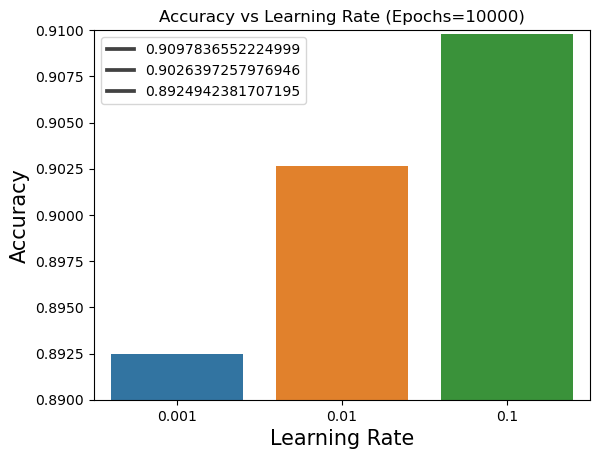

In [145]:
ax=sns.barplot(x=[0.1,0.01,0.001],y=R2_scores_lr)
legend=ax.legend(R2_scores_lr)
title=ax.set_title("Accuracy vs Learning Rate (Epochs=10000)")
ax.set_xlabel("Learning Rate",size=15)
ax.set_ylim([0.890,0.910])
ylabel=ax.set_ylabel("Accuracy",size=15)

## There's not really a big difference, but we see that over the same scale, Learning rate affects the Accuracy more than the Number of Epochs

In [63]:
R2_score(X_train_norm@weights,Y_train_norm) #EXPECTED COZ THAT'S WHAT THE MODEL WAS TRAINED ON

0.905903242476427

In [64]:
#lET'S SEE ON THE TESTING DATA
X_test=test.drop("Weight",axis=1)
Y_test=test["Weight"]
X_test_norm=Normalize(X_test)
Y_test_norm=Normalize(Y_test)
X_test_norm.insert(0,"Bias",np.ones(len(X_test_norm)))

In [65]:
R2_score(X_test_norm@weights,Y_test_norm)#Well, doing great actually!!!

0.8484312806322417

In [66]:
#Make a sample prediction, Adding a bias term to the series is a lil tricky
rand_ind=np.random.randint(len(X_test))
sample_dino_stat=X_test_norm.iloc[rand_ind]
sample_dino_weight=Y_test.iloc[rand_ind]

In [67]:
sample_dino_stat

Bias            1.000000
Species        -0.577258
Length         -0.152579
Age            -0.201373
TailLength     -0.280918
Height         -0.342323
Width          -0.078451
Gender         -0.620786
Completeness   -0.950828
Name: 26, dtype: float64

In [68]:
def make_prediction(sample_dino_stat):
    pred=np.dot(sample_dino_stat,weights)*Y_train.std() + Y_train.mean() 
    print(pred)#This is the Predicted weight of a single Dino picked
make_prediction(sample_dino_stat)

319.3891675699275


In [69]:
print("Actual Weight",sample_dino_weight) #Umm here it messed up, no matter what, the weight should never be negative right???

Actual Weight 218.0


## Graphs for Dino Tim

In [70]:
np.mean(cost_history,axis=1)

array([0.05482777, 0.0532443 , 0.05174586, ..., 0.00083265, 0.00083265,
       0.00083265])

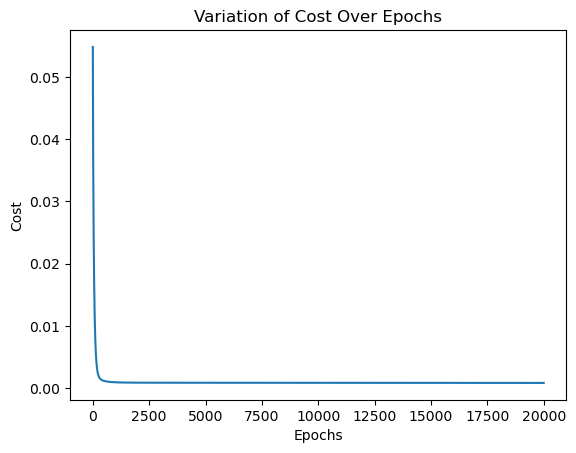

In [71]:
#Let's plot the mean cost over the epochs
import matplotlib.pyplot as plt
epochs=20000
plt.plot(np.arange(epochs),np.mean(cost_history,axis=1))
x_label=plt.xlabel("Epochs")
y_label=plt.ylabel("Cost")
title=plt.title("Variation of Cost Over Epochs")

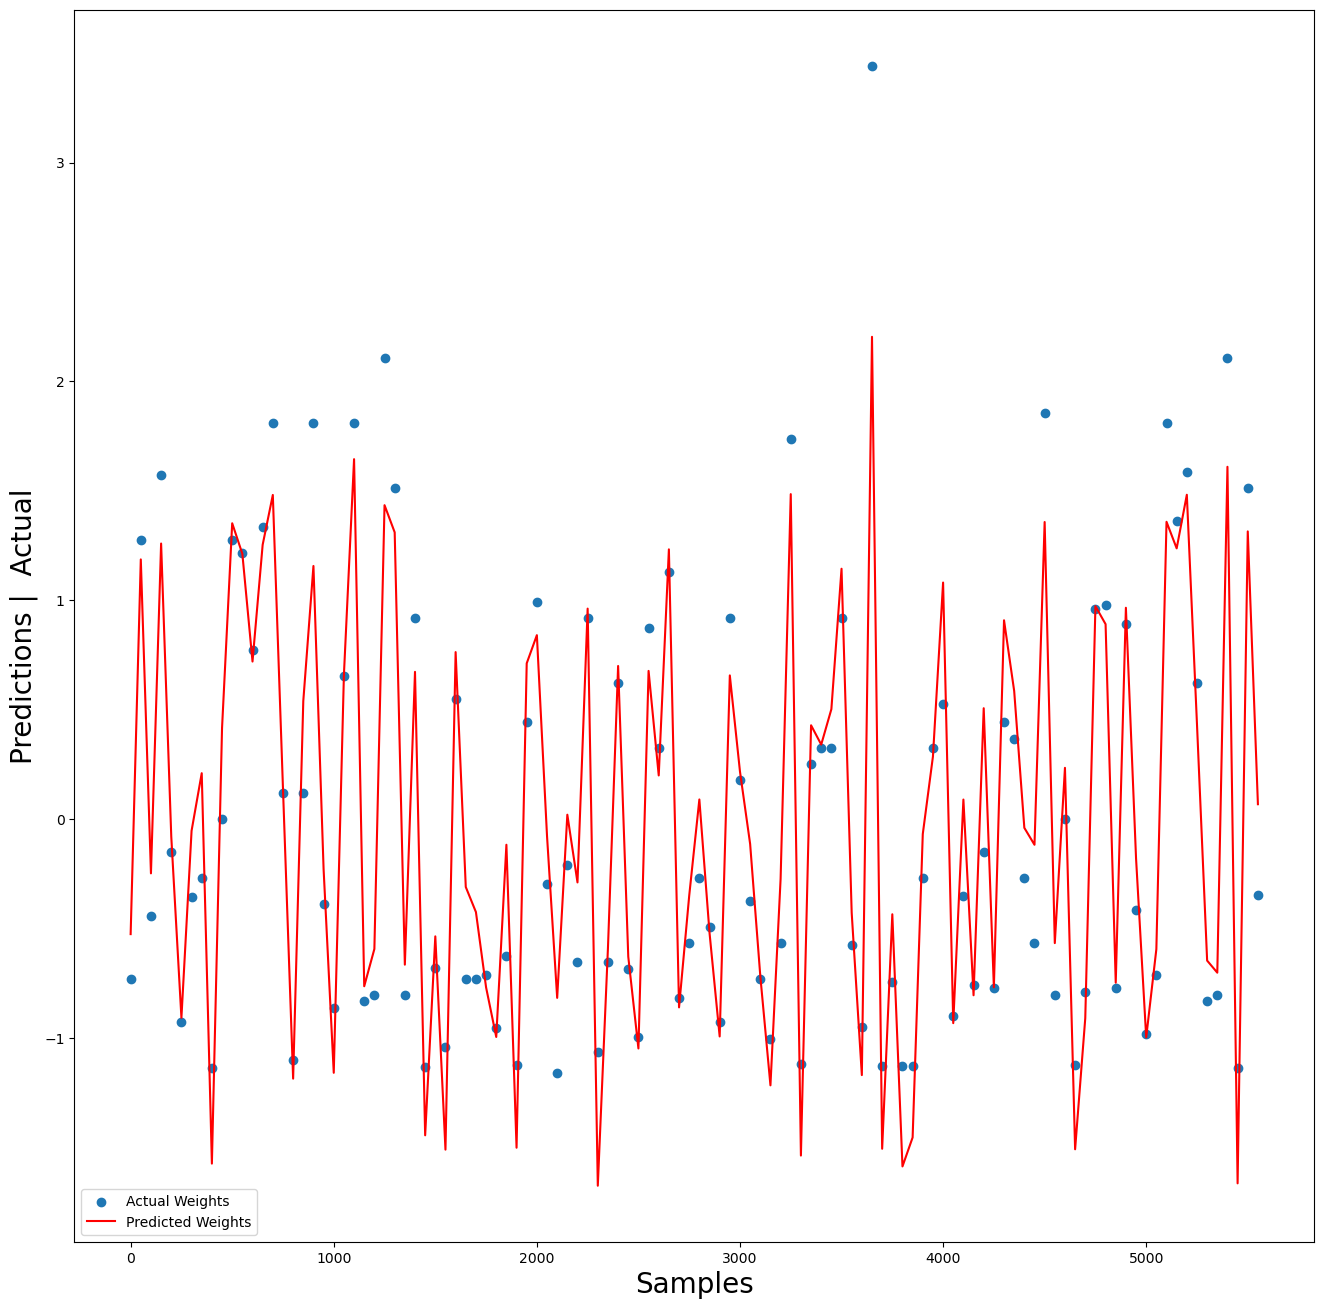

In [72]:
fig=plt.figure(figsize=(16,16))
plt.scatter(range(0,len(Y_train)*50,50),Y_train_norm)
line=plt.plot(range(0,len(Y_train)*50,50),X_train_norm@weights,color="red")
leg=plt.legend(["Actual Weights","Predicted Weights"],loc="lower left")
xlabel=plt.xlabel("Samples")
xlabel.set_fontsize(20)
y_label=plt.ylabel("Predictions |  Actual")
y_label.set_fontsize(20)

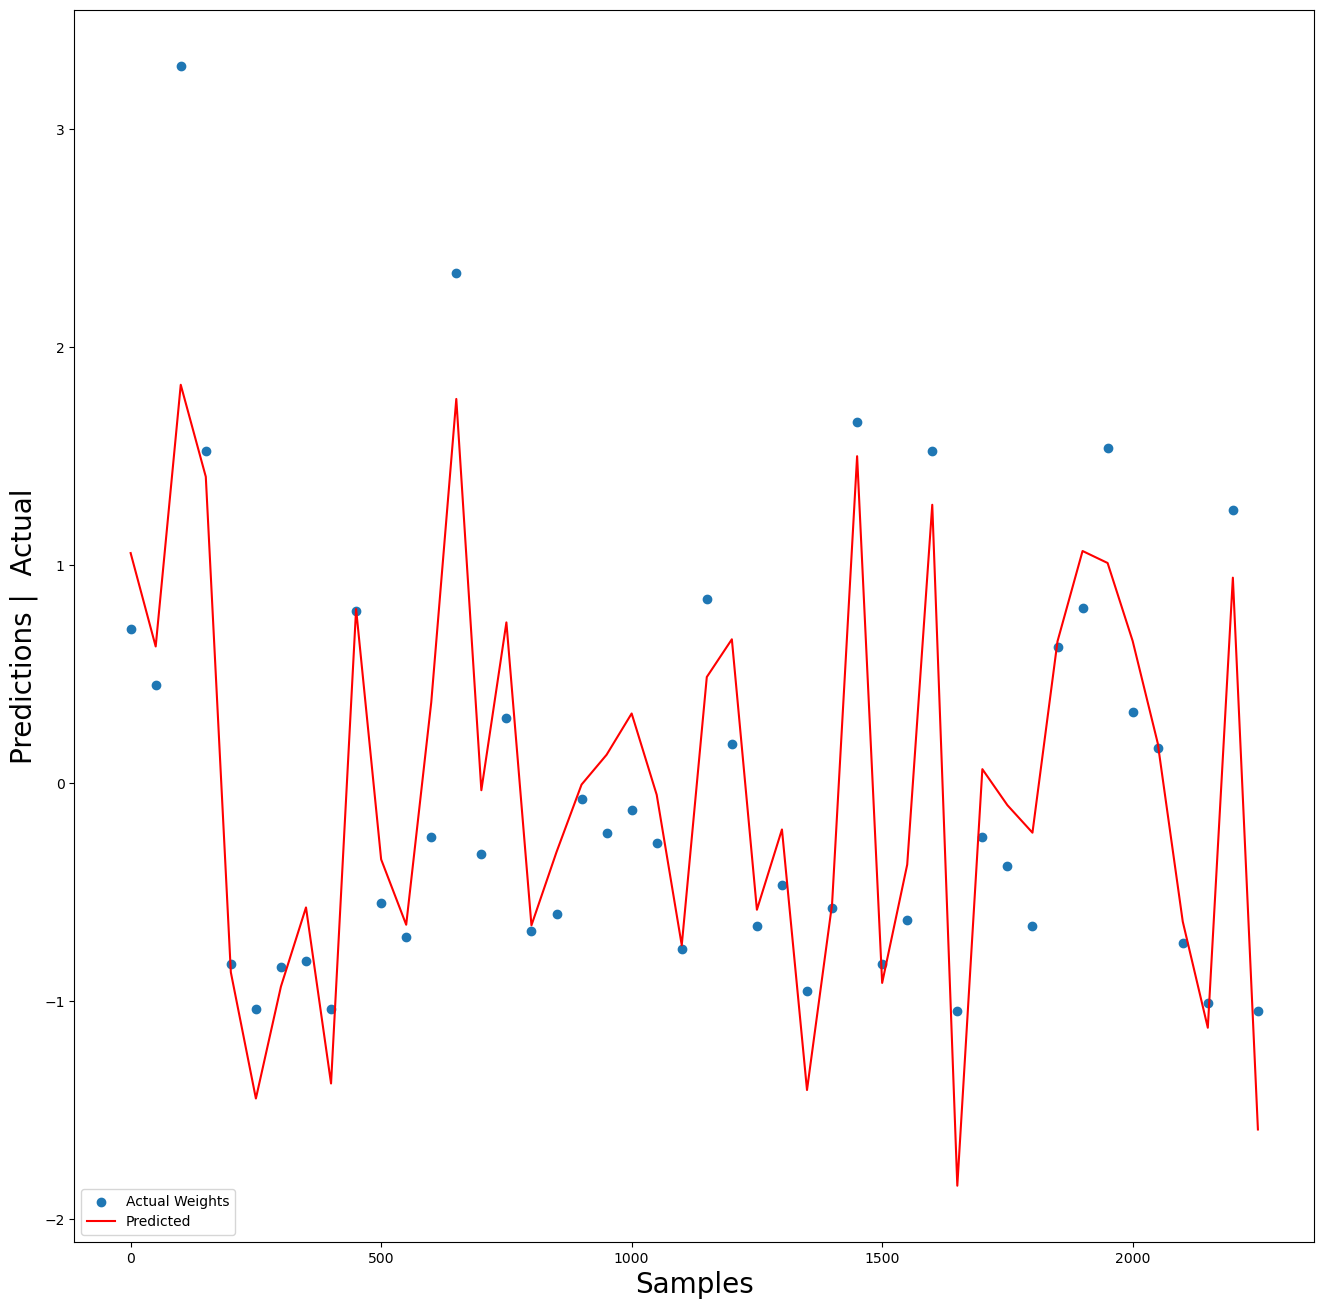

In [73]:
fig=plt.figure(figsize=(16,16))
plt.scatter(range(0,len(Y_test)*50,50),Y_test_norm)
#plt.xlim(0,5000)
line=plt.plot(range(0,len(Y_test)*50,50),X_test_norm@weights,color="red")
plt.legend(["Actual Weights","Predicted"],loc="lower left")
xlabel=plt.xlabel("Samples")
xlabel.set_fontsize(20)
y_label=plt.ylabel("Predictions |  Actual")
y_label.set_fontsize(20)